In [1]:
# Install catalax
# !pip install catalax

In [2]:
import json
import jax.numpy as jnp
import numpy as np

import catalax as ctx
import catalax.mcmc as cmc

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p3ga_pgm, k_p2ga_pgm, vf_pgm, keq_pgm, k_PEP_eno, k_p2ga_eno, keq_eno, vf_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,k_PEP_eno,k_PEP_eno,0.50,False,None,None,None,None
1,k_p2ga_eno,k_p2ga_eno,0.04,False,None,None,None,None
2,k_p2ga_pgm,k_p2ga_pgm,0.08,False,None,None,None,None
3,k_p3ga_pgm,k_p3ga_pgm,1.20,False,None,None,None,None
4,keq_eno,keq_eno,6.70,False,None,None,None,None
5,keq_pgm,keq_pgm,0.19,False,None,None,None,None
6,vf_eno,vf_eno,1.35,False,None,None,None,None
7,vf_pgm,vf_pgm,9.40,False,None,None,None,None


In [4]:
data = jnp.load("C:/Users/danic/OneDrive/Desktop/Kamo_Data.npy")
time = jnp.load("C:/Users/danic/OneDrive/Desktop/Kamo_Time.npy")
y0s = jnp.load("C:/Users/danic/OneDrive/Desktop/Kamo_AllInitials.npy")
initial_conditions = json.load(open("C:/Users/danic/OneDrive/Desktop/model_kamo.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)


print(f"Time: {time.shape} | Data: {data.shape}")

Time: (18, 19) | Data: (18, 19, 3) | Initial Conditions: (18, 3)
(18, 19, 3)
(18, 19)
(18, 3)
Time: (18, 19) | Data: (18, 19, 3)


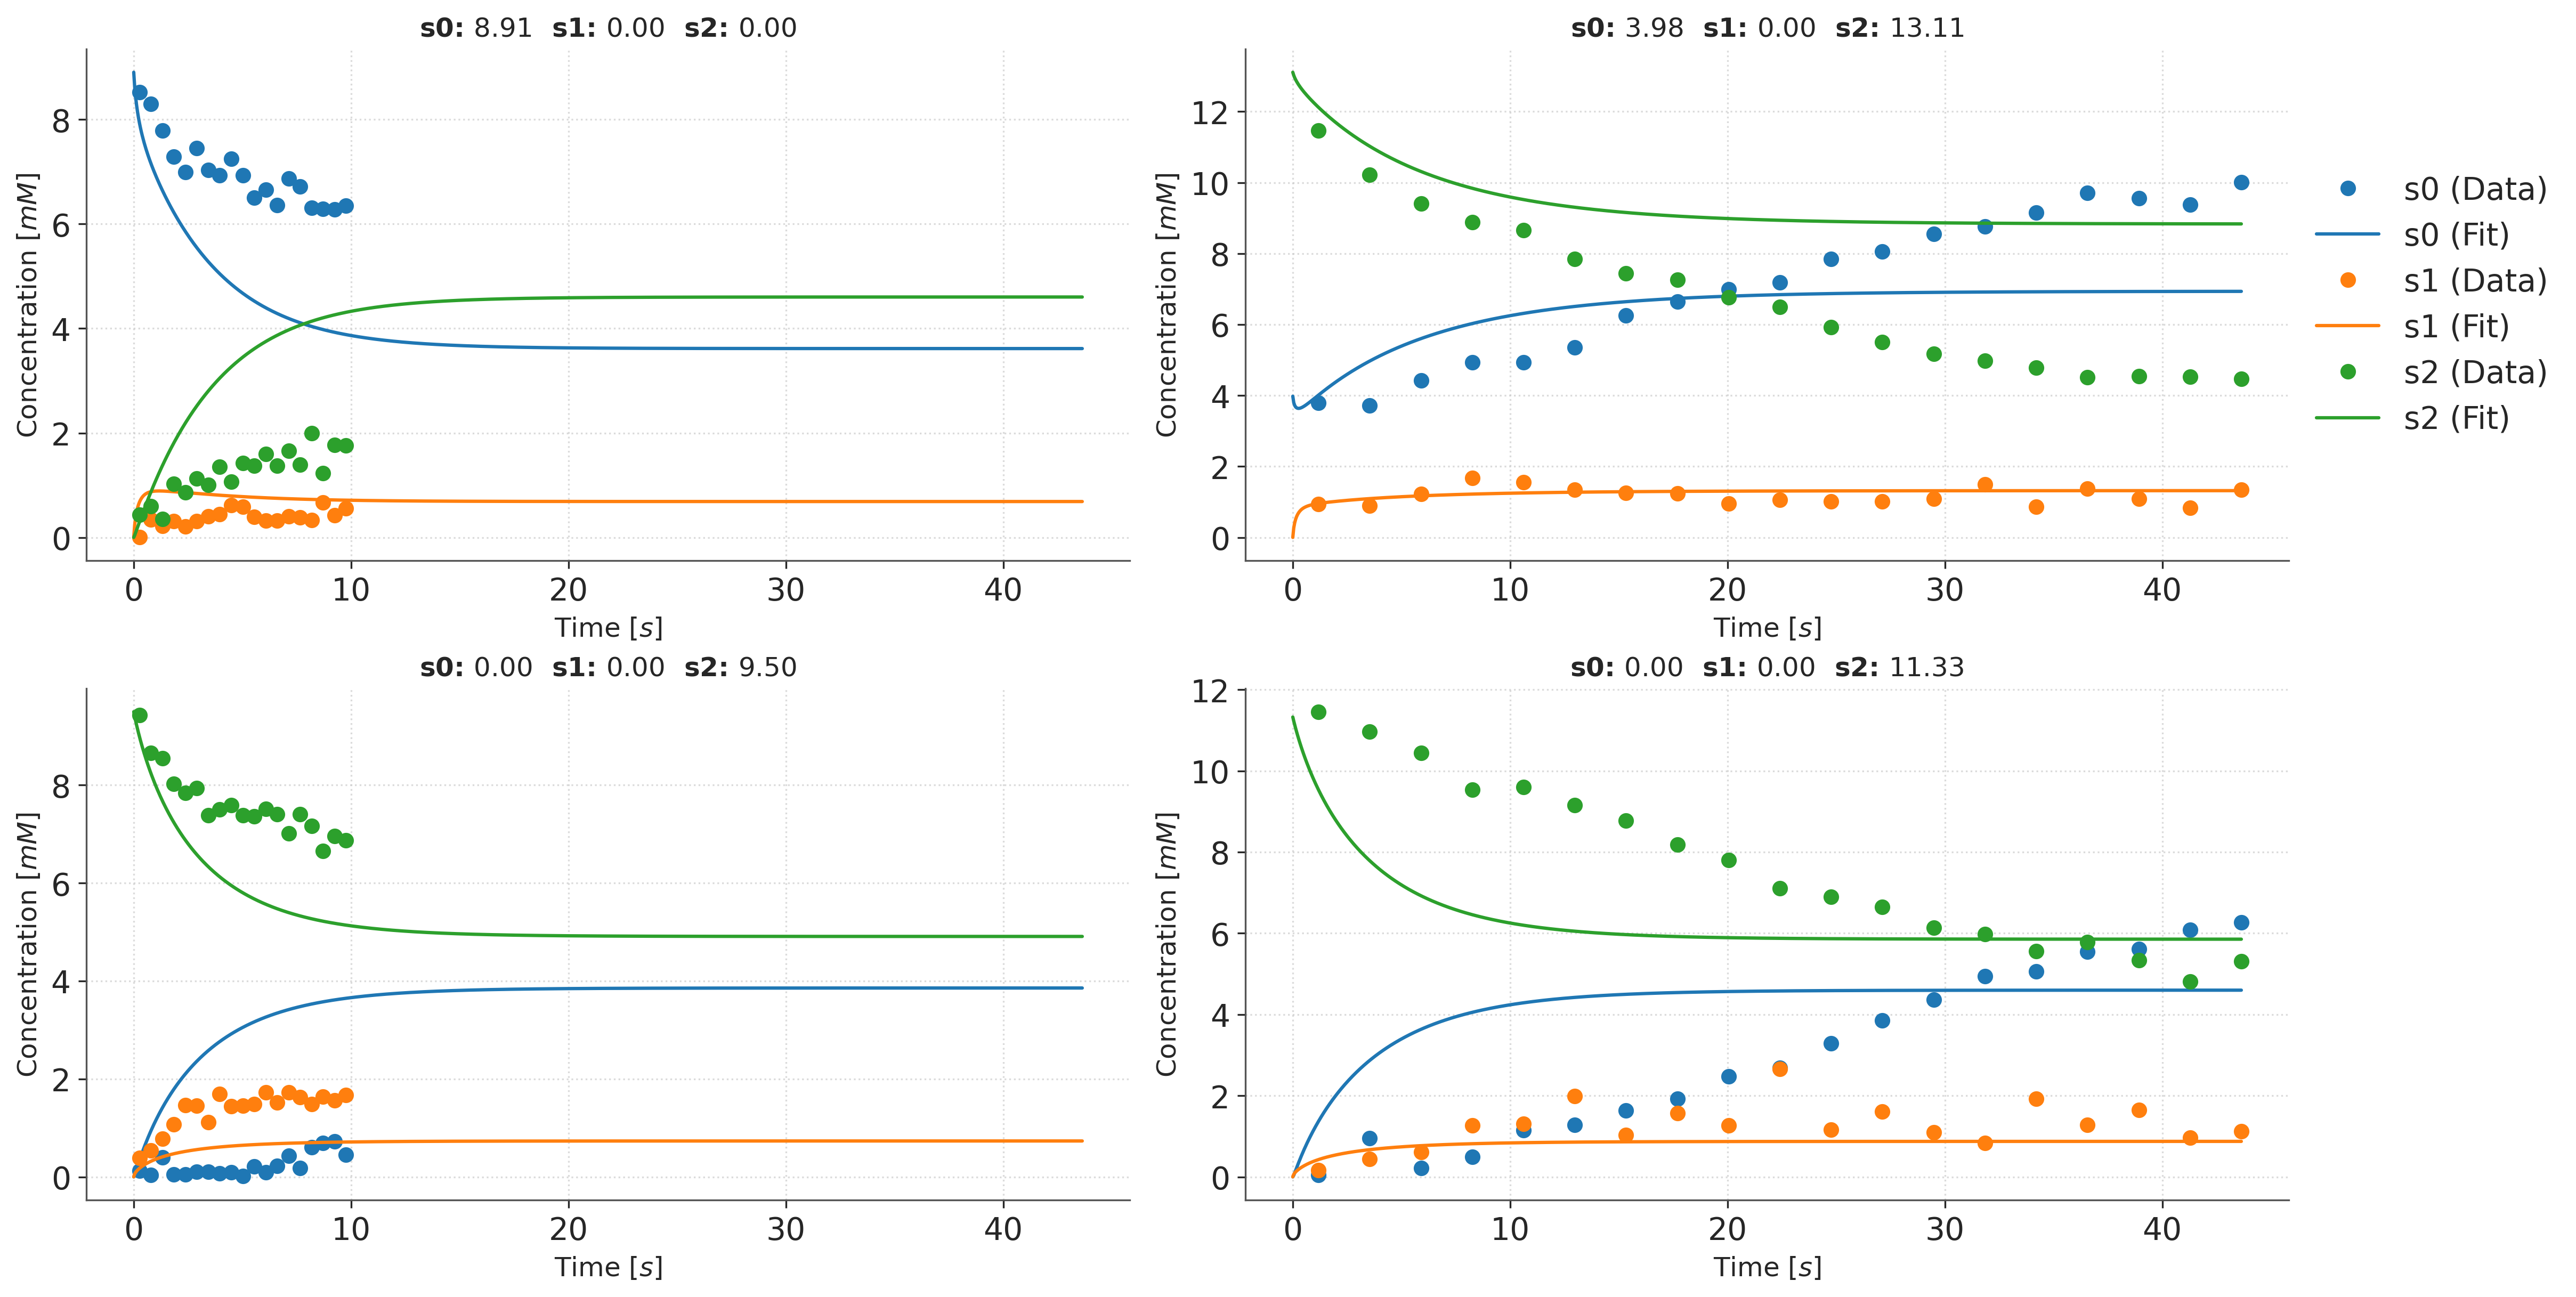

In [5]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8,4),
)

In [6]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-6, high=200.0)


# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [8]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64**4
)

🔸 Priors
├── k_p3ga_pgm: U(low=1e-06, high=200.0)
├── k_p2ga_pgm: U(low=1e-06, high=200.0)
├── vf_pgm: U(low=1e-06, high=200.0)
├── keq_pgm: U(low=1e-06, high=200.0)
├── k_PEP_eno: U(low=1e-06, high=200.0)
├── k_p2ga_eno: U(low=1e-06, high=200.0)
├── keq_eno: U(low=1e-06, high=200.0)
├── vf_eno: U(low=1e-06, high=200.0)

🚀 Running MCMC



warmup:   1%|▍                            | 26/2000 [00:16<12:25,  2.65it/s, 50 steps of size 5.26e-02. acc. prob=0.73]jax.pure_callback failed
Traceback (most recent call last):
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\callback.py", line 77, in pure_callback_impl
    return callback(*args)
           ^^^^^^^^^^^^^^^
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\callback.py", line 65, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\equinox\_errors.py", line 70, in raises
    raise EqxRuntimeError(msgs[_index.item()])
equinox._errors.EqxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.
warmup:   1%|▎                          | 26/2000 [02:18<2:54:44,  5.31s/it, 50 steps of size 5.26e-02. acc. prob=0.73]


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
  File "C:\Users\danic\anaconda3\envs\test\Lib\asyncio\windows_events.py", line 321, in run_forever
  File "C:\Users\danic\anaconda3\envs\test\Lib\asyncio\base_events.py", line 608, in run_forever
  File "C:\Users\danic\anaconda3\envs\test\Lib\asyncio\base_events.py", line 1936, in _run_once
  File "C:\Users\danic\anaconda3\envs\test\Lib\asyncio\events.py", line 84, in _run
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
  File "C:\Users\danic\AppData\Local\Temp\ipykernel_25484\4134352481.py", line 2, in <module>
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\mcmc\mcmc.py", line 130, in run_mcmc
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\numpyro\infer\mcmc.py", line 634, in run
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\numpyro\infer\mcmc.py", line 440, in _single_chain_mcmc
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\numpyro\util.py", line 367, in fori_collect
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\pjit.py", line 298, in cache_miss
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\pjit.py", line 176, in _python_pjit_helper
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\core.py", line 2788, in bind
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\core.py", line 425, in bind_with_trace
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\core.py", line 913, in process_primitive
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\pjit.py", line 1488, in _pjit_call_impl
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\pjit.py", line 1471, in call_impl_cache_miss
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\pjit.py", line 1427, in _pjit_call_impl_python
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\profiler.py", line 335, in wrapper
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\interpreters\pxla.py", line 1205, in __call__
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\interpreters\mlir.py", line 2466, in _wrapped_callback
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\callback.py", line 219, in _callback
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\callback.py", line 80, in pure_callback_impl
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\jax\_src\callback.py", line 65, in __call__
  File "C:\Users\danic\anaconda3\envs\test\Lib\site-packages\equinox\_errors.py", line 70, in raises
EqxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

In [ ]:
np.mean?

In [ ]:
mcmc

In [ ]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

In [ ]:
# Plot the trace of the MCMC (Posterior dist and chain trace)
f = cmc.plot_trace(mcmc, model)

In [ ]:
# Variant of plotting the posterior with HDPI
f = cmc.plot_posterior(mcmc, model)

In [ ]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#       

#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.


f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(10,5),
    mcmc=mcmc
)